In [608]:
%pylab inline
import scipy as sp
from numba import jit

Populating the interactive namespace from numpy and matplotlib


In [609]:
@jit
def nrmse(output,target):
    combinedVar = 0.5 * (np.var(target, ddof=1) + np.var(output, ddof=1))
    errorSignal = output - target
    return np.sqrt(np.mean(errorSignal ** 2) / combinedVar)

In [610]:
def generateInternalWeights(nInternalUnits, connectivity):
    success = False
    internalWeights = 0
    while success == False:
        try:
            internalWeights = np.random.randn(nInternalUnits,nInternalUnits) * (np.random.random((nInternalUnits,nInternalUnits)) < connectivity)
            specRad = abs(np.linalg.eig(internalWeights)[0][0])
            if (specRad > 0):
                internalWeights = internalWeights / specRad
                success = True
        except e:
            print(e)
    return internalWeights

/Volumes/LocalDataHD/virtualenvs/env3/chrysalisConceptors


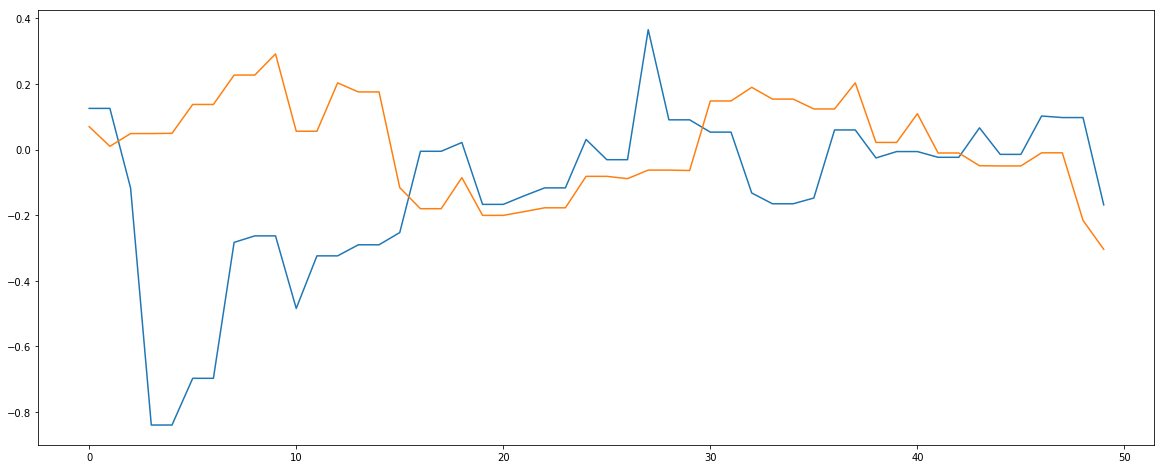

In [1007]:
import os
# get current working path
cwd = os.getcwd()
print( cwd )

# load gesture 1
# gesture1 = np.loadtxt(cwd + '/workshop/gesturedata_0.txt')
# gesture2 = np.loadtxt(cwd + '/workshop/gesturedata_1.txt')
gesture1 = np.loadtxt(cwd + '/supercollider/gesturedata_1_2.txt')
gesture2 = np.loadtxt(cwd + '/supercollider/gesturedata_5_2.txt')

# plot the two gestures
figsize(20,8);
gesture1 = (gesture1 * 250) 
gesture2 = (gesture2 * 250) 

plot( gesture1)
plot( gesture2)


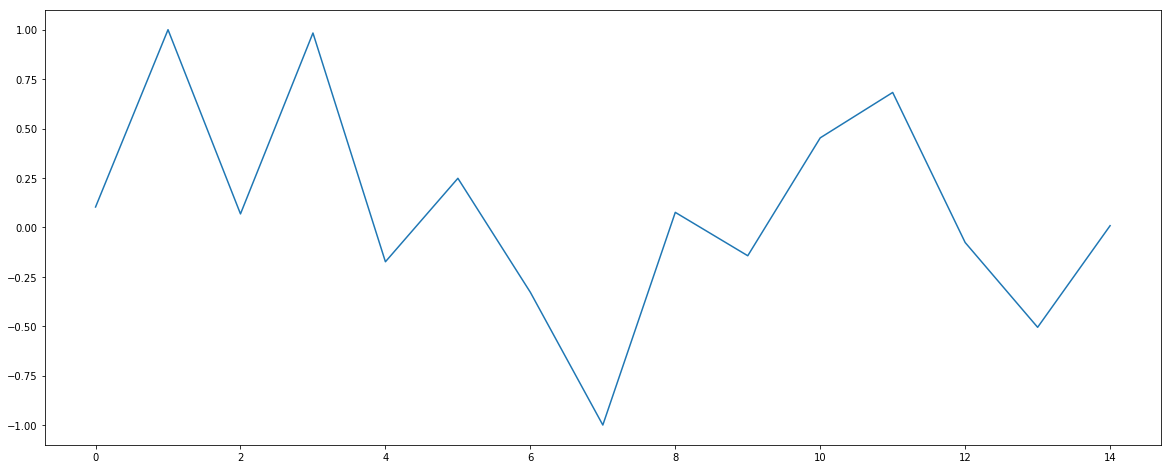

In [877]:
#plot(np.tanh(np.random.randn(10)))
def makeRandomWalk(len):
    pt = zeros(len)
    pt[0] = np.random.randn(1)
    for n in range(pt.size-1):
        pt[n+1] = pt[n] + np.random.randn(1)
    pt = pt - np.min(pt)
    pt = (pt / np.max(pt) * 2) - 1
    return pt
    

#plot()
plot(makeRandomWalk(15))

[-0.41045088 -0.2642768 ]


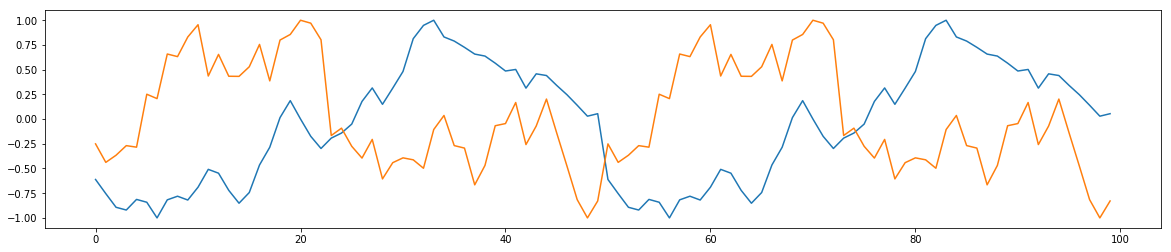

In [1096]:
figsize(20,4)
# pSaw = lambda n: (round(n % waveLengthSamples) / waveLengthSamples * 2) - 1.0
# plot([pSaw(x) for x in arange(300)])
# pPulse = lambda n: (((n % waveLengthSamples) < (waveLengthSamples * 0.5)) * 2) - 1.0
# plot([pPulse(x) for x in arange(300)])
# pSine2 = lambda n: (sin(n) * sin((n+pi/4)/6))
# plot([pSine2(x) for x in arange(100)])
# pSine3 = lambda n: (sin(n) * sin((n/4)/6)/6)
# plot([pSine3(x) for x in arange(100)])

pJ1 = lambda n: 1 * sin(2 * pi * n / 3.1504531)
# plot([pJ1(x) for x in arange(100)])
pJ1b = lambda n, d: 1 * sin(n/d) ** 1
# plot([pJ1b(x,2) for x in arange(100)])

period2 = 2
rawp = np.random.randn(period2)
# rawp = np.array([1.1929,2.6856]);
maxVal = np.max(rawp)
minVal = np.min(rawp)
print(rawp)
rp = 0.5 * (2 * (rawp - minVal) / (maxVal - minVal) - 1);
pJ2 = lambda n: rp[mod(n, period2 )]
# plot([pJ2(x) for x in arange(100)])

#pTri = lambda n,p: (n % (p/2)) * ((n % p) > 0.5)
# pTri = lambda n,p: ((((n % p) >= (p/2)) * ((p/2) - (n % (p/2))) + ((n % p) < (p/2)) * (n % (p/2))) * (2/p)) * 2 -1
# #pTri = lambda n,p: (n % (p/2))
# plot([pTri(x,10) for x in arange(100)])

patternLength = 50
p_rw1 = makeRandomWalk(patternLength)
p_rw2 = makeRandomWalk(patternLength)
pLoop = lambda n,p: p[n%p.size]
plot([pLoop(x,p_rw1) for x in arange(100)])
plot([pLoop(x,p_rw2) for x in arange(100)])


In [1]:

def makeClassifierNetwork(p):
    Netconnectivity = 1
    if p['N'] > 20:
        Netconnectivity = 10.0/p['N'];
    WstarRaw = generateInternalWeights(p['N'], Netconnectivity)
    WinRaw = 2 * (np.random.rand(p['N'], 1) - 0.5)
    WbiasRaw = 2 * (np.random.rand(p['N'], 1) - 0.5)

    #Scale raw weights     
    Wstar = p['NetSR'] * WstarRaw;
    W = Wstar
    Win = p['NetinpScaling'] * WinRaw;
    Wbias = p['BiasScaling'] * WbiasRaw;  
    I = np.eye(p['N'])
    xCollector = np.zeros((p['N'], p['learnLength']))
    pCollector = np.zeros((1, p['learnLength']))
    x = np.zeros((p['N'],1))
    
    allTrainxArgs = np.zeros((p['N'] + 1, 0));
    allTrainOldxArgs = np.zeros((p['N'], 0));
    allTrainWtargets = np.zeros((p['N'], 0));
    allTrainOuts = np.zeros((1, 0));
    patternRs =  np.zeros((1, p['patts'].size), dtype=np.object)
    
    for i_pattern in range(p['patts'].size):
        print('Observing pattern ', i_pattern)
        patt = p['patts'][i_pattern]
        xCollector = np.zeros((p['N'] + 1, p['learnLength']));
        xOldCollector = np.zeros((p['N'], p['learnLength']));
        WTargetCollector = np.zeros((p['N'], p['learnLength']));
        pCollector = np.zeros((1, p['learnLength']));
        x = np.zeros((p['N'], 1));

        for n in range(p['washoutLength'] + p['learnLength']):
            u = patt(n+1)
            xOld = x
            Wtarget = (Wstar.dot(x)) + (Win.dot(u))
            x = ((1.0-p['LR']) * xOld) + (p['LR'] * tanh(Wtarget + Wbias))
            if n >= p['washoutLength']:
                xCollector[:, n - p['washoutLength']] = np.concatenate((x[:,0], np.array([1])))
                xOldCollector[:, n - p['washoutLength']] = xOld[:,0]
                WTargetCollector[:, n - p['washoutLength']] = Wtarget[:,0]
                pCollector[0, n - p['washoutLength']] = u
            uOld = u
        
        R = xCollector[0:-1].dot(xCollector[0:-1].T) / p['learnLength']
        patternRs[0,i_pattern] = R
        allTrainxArgs = np.concatenate((allTrainxArgs, xCollector), axis=1)
        allTrainOldxArgs = np.concatenate((allTrainOldxArgs, xOldCollector), axis=1)
        allTrainOuts = np.concatenate((allTrainOuts, pCollector), axis=1)
        allTrainWtargets = np.concatenate((allTrainWtargets, WTargetCollector), axis=1)

    return locals()

params = {'N':32, 'NetSR':1.3, 'NetinpScaling':1.9,'BiasScaling':0.3,
         'washoutLength':gesture1.size * 10, 'learnLength':gesture1.size * 2, 
          'LR': 0.6,
#           'patts':np.array([lambda x:pLoop(x,p_rw1), lambda x: pLoop(x,p_rw2)])
          'patts':np.array([lambda x:pLoop(x,gesture1), lambda x: pLoop(x,gesture2)])
         }

net = makeClassifierNetwork(params)


NameError: name 'gesture1' is not defined

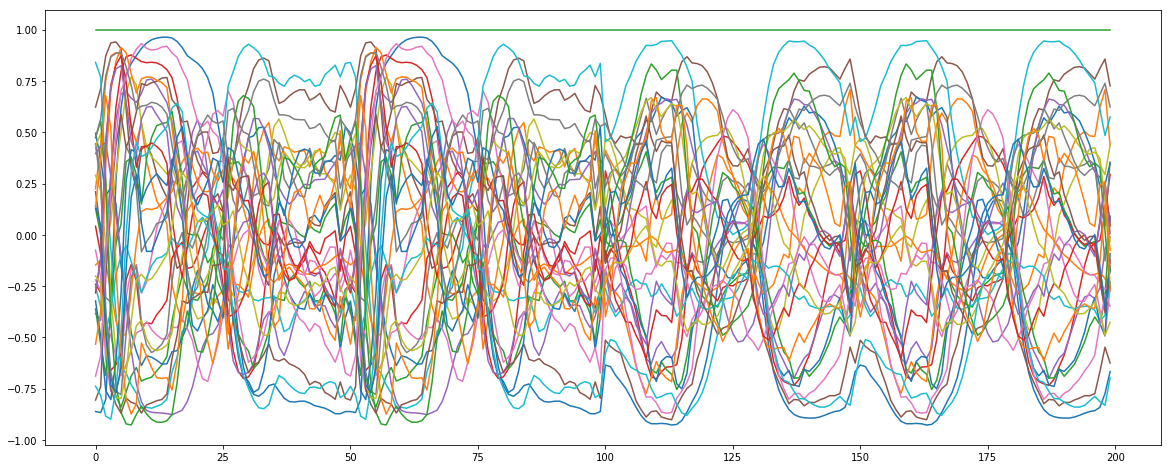

In [1098]:
figsize(20,8)
plot(net['allTrainxArgs'].T)
None

In [1074]:

def computeConceptors(p, net, alphas):
    print('Computing conceptors, alphas: ', alphas)
    Cs = np.zeros((4, p['patts'].size), dtype=np.object)
    for i_pattern in range(p['patts'].size):
        R = net['patternRs'][0,i_pattern]
        [U,s,V] = svd(R)
        S = diag(s)
        Snew = (S * linalg.inv(S + pow(alphas[i_pattern], -2) * np.eye(p['N'])))

        C =  U.dot(Snew).dot(U.T);
        Cs[0,i_pattern] = C
        Cs[1,i_pattern] = U
        Cs[2,i_pattern] = diag(Snew)
        Cs[3,i_pattern] = diag(S)
    return locals()

cnet = computeConceptors(params, net, np.array([10,20.0]))

Computing conceptors, alphas:  [ 10.  20.]


In [1]:
import scipy.spatial.distance as dist


def plotConceptorPatterns(p, cNet, subr, suboff, recallTestLength):
    x_CTestPL = np.zeros((3, recallTestLength, p['patts'].size))
    p_CTestPL = np.zeros((1, recallTestLength, p['patts'].size))
    cx_CTestPL = np.zeros((p['patts'].size,recallTestLength))
    pat_CTestPL = np.zeros((1,recallTestLength))
    
    for i_pattern in range(p['patts'].size):
        patt = p['patts'][i_pattern]
        x = np.zeros((p['N'],1))
        for n in range(recallTestLength + p['washoutLength']):
            u = patt(n+1)
            xOld = x
            Wtarget = (cNet['net']['W'].dot(x)) + (cNet['net']['Win'].dot(u))
            x = ((1.0-p['LR']) * xOld) + (p['LR'] * tanh(Wtarget + cNet['net']['Wbias']))
            if (n > p['washoutLength']):
                pat_CTestPL[0,n-p['washoutLength'] ] = u
                C = cNet['Cs'][0,0]
                C2 = cNet['Cs'][0,1]
                cx = x.T.dot(C.dot(x)) + x.T.dot((1.0-C2).dot(x))
                cx_CTestPL[0,n-p['washoutLength']] = cx
                cx2 = x.T.dot(C2.dot(x)) + x.T.dot((1.0-C).dot(x))
#                 cx2 = x.T.dot(C2.dot(x))
                cx_CTestPL[1,n-p['washoutLength']] = cx2
#                 cxNeither = x.T.dot((1.0 - C2).dot(x)) + x.T.dot((1.0-C).dot(x))
#                 cx_CTestPL[2,n-p['washoutLength']] = cxNeither

        ax = subplot(subr, 2, suboff + i_pattern + 1)
        ax.set_title("Sample " + str(suboff/2) + ", pattern: " + str(i_pattern) + ", alphas: " + str(cNet['alphas']))
#         plot([p['patts'][i_pattern](x) for x in arange(recallTestLength)])
        plot(pat_CTestPL.T)
        plot(cx_CTestPL.T)
        classificationScore = np.sum(cx_CTestPL[i_pattern] > cx_CTestPL[1 - i_pattern]) / cx_CTestPL[0].size
        separation = dist.euclidean(cx_CTestPL[i_pattern],cx_CTestPL[1-i_pattern])
        print("Pattern ", str(i_pattern), " classification score: ", classificationScore, ", separation: ", separation)
        #testing

    return locals()


In [1094]:
params = restored['net']['p']
net = restored['net']

0
Computing conceptors, alphas:  [ 37.10569349  72.09425499]
Pattern  0  classification score:  0.99 , separation:  2.749423288018889
Pattern  1  classification score:  0.99 , separation:  12.012714495221589
1
Computing conceptors, alphas:  [ 98.95304018  63.82129198]
Pattern  0  classification score:  0.99 , separation:  3.224139219337374
Pattern  1  classification score:  0.99 , separation:  10.158082801889883
2
Computing conceptors, alphas:  [ 72.11087576   8.21699549]
Pattern  0  classification score:  0.99 , separation:  18.616733836385944
Pattern  1  classification score:  0.99 , separation:  9.839317538927354
3
Computing conceptors, alphas:  [ 35.2345481   39.25440504]
Pattern  0  classification score:  0.99 , separation:  5.1662034812973845
Pattern  1  classification score:  0.99 , separation:  12.050326036821614
4
Computing conceptors, alphas:  [ 87.58699825  73.77678405]
Pattern  0  classification score:  0.99 , separation:  2.786399209780843
Pattern  1  classification score:

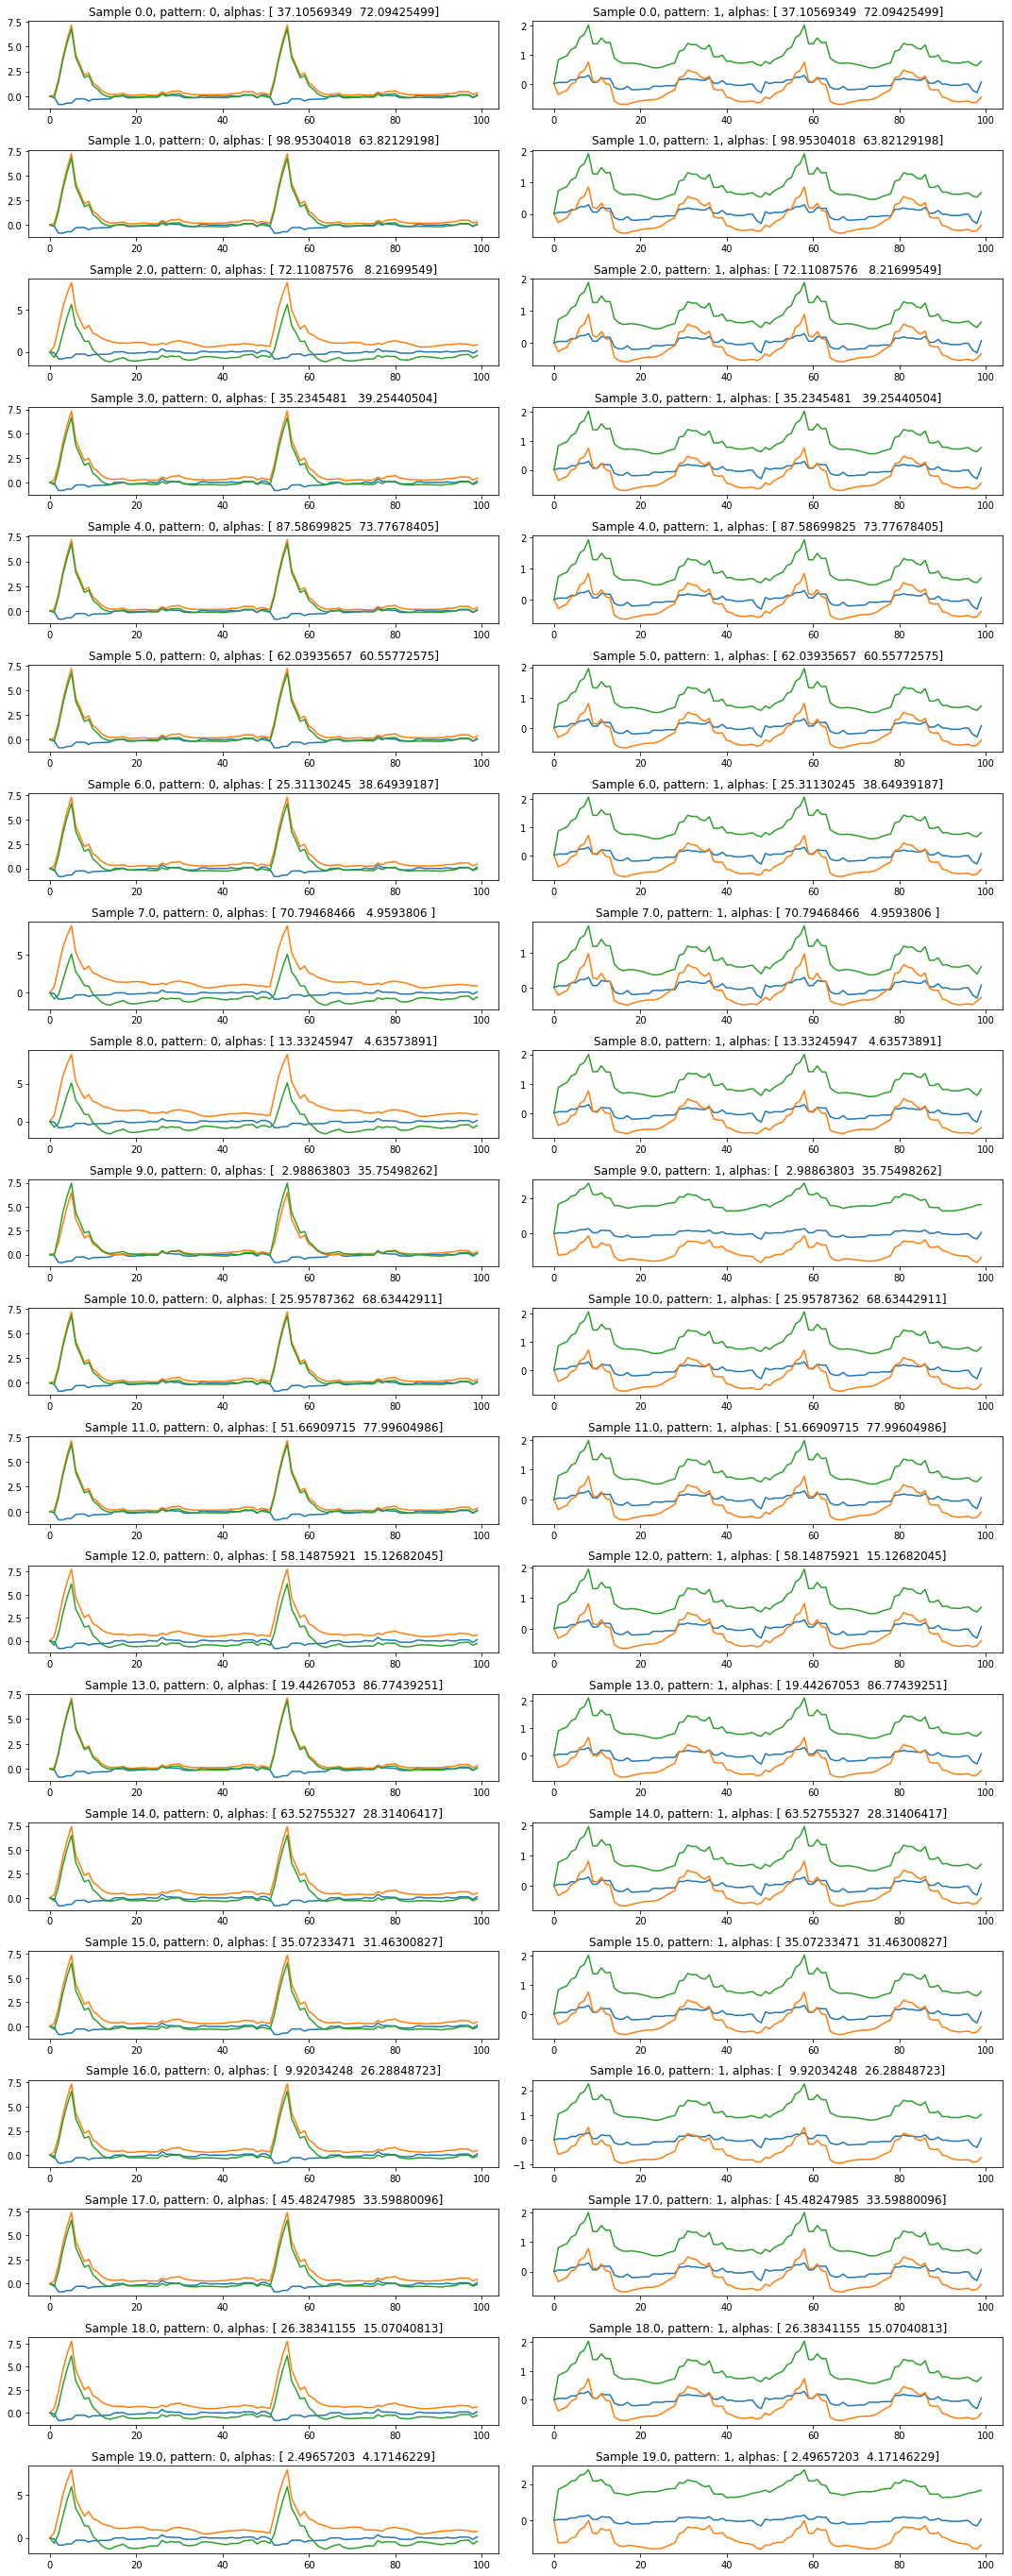

In [1095]:
conceptorSampleSize = 20
conceptorNets = np.zeros(conceptorSampleSize, dtype=np.object)
figsize(15,conceptorSampleSize * 1.9)
for i_cnet in range(conceptorSampleSize):
    print(i_cnet)
    conceptorNets[i_cnet] = computeConceptors(params, net, np.random.random(2) * 100)
    pq = plotConceptorPatterns(params, conceptorNets[i_cnet], conceptorSampleSize, i_cnet * 2, 100)
plt.tight_layout();


Pattern  0  classification score:  0.99 , separation:  21.120009493112786
Pattern  1  classification score:  0.99 , separation:  11.498202591132255


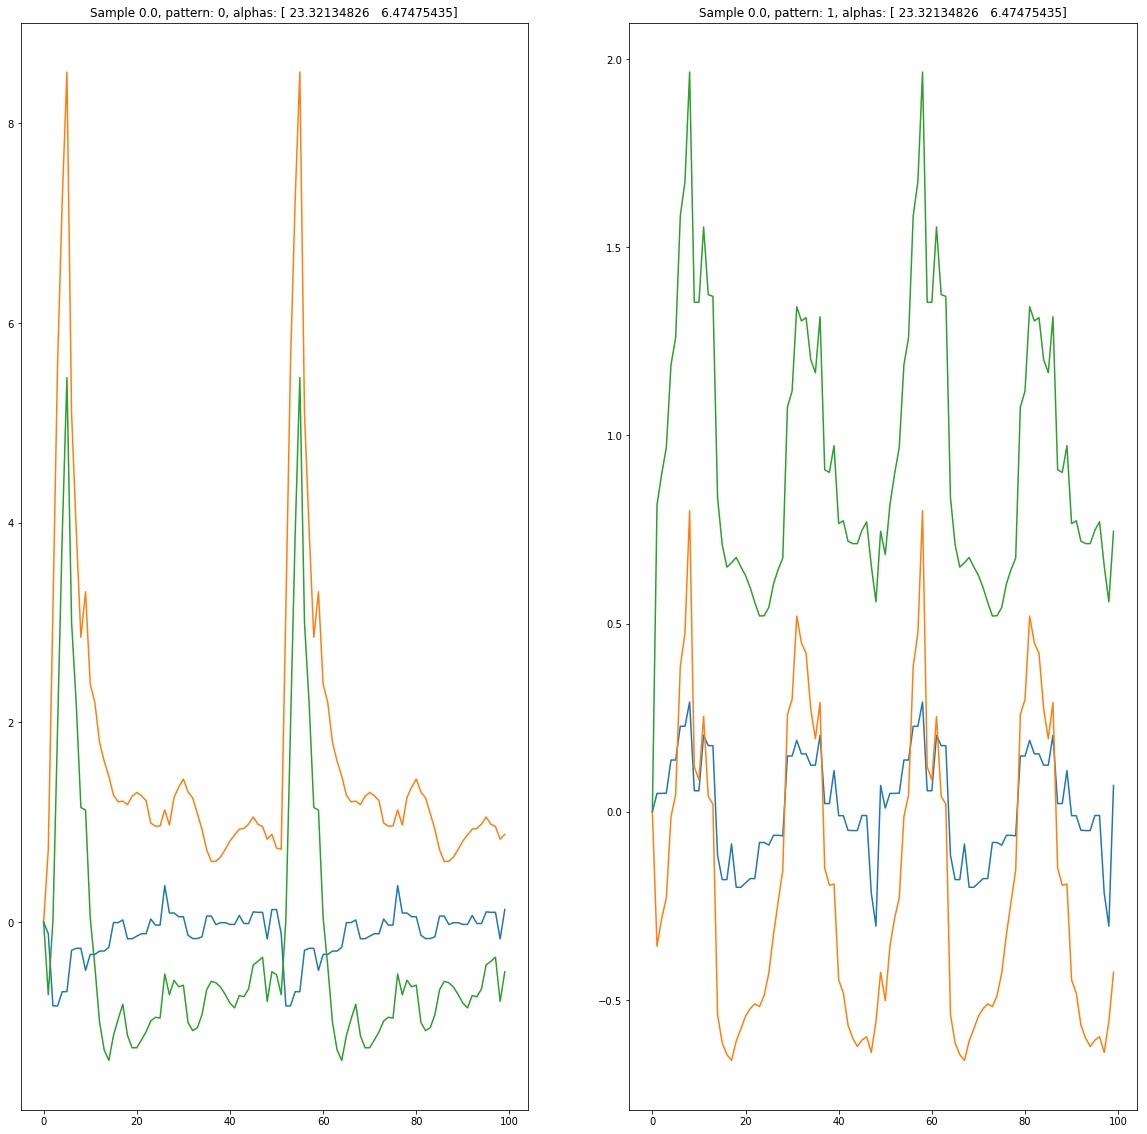

In [855]:
figsize(20,20)
plotConceptorPatterns(params, conceptorNets[17], 1, 0, 100)
None

In [486]:
a = np.ones(100) * 30
# a[5] = 0
b = np.ones(100) * 2

In [488]:
np.sum(a > b) / a.size

1.0

In [857]:
import dill as pickle
ts = str(datetime.datetime.timestamp(datetime.datetime.now()))
with open(r"models/classifier_2_" + ts + ".pickled", "wb") as output_file:    
    pickle.dump(conceptorNets[17], output_file, protocol=0)

In [36]:
serialised  = pickle.dumps(conceptorNets[0], protocol=0) 

In [38]:
restored = pickle.loads(serialised)

In [569]:
@jit
def iterateClassifier(net, state, u):
    state['xOld'] = state['x']
    Wtarget = (net['net']['W'].dot(state['x'])) + (net['net']['Win'].dot(u))
    state['x'] = ((1.0-net['p']['LR']) * state['xOld']) + (net['p']['LR'] * tanh(Wtarget + net['net']['Wbias']))
    C = net['Cs'][0,0]
    C2 = net['Cs'][0,1]
    x = state['x']

    state['evidence'][0] = x.T.dot(C.dot(x)) + x.T.dot((1.0-C2).dot(x))
    state['evidence'][1] = x.T.dot(C2.dot(x)) + x.T.dot((1.0-C).dot(x))
    return state

In [570]:
state = createState(restored)

In [604]:
%%time
state = iterateClassifier(restored, state, 0.3)
# state['evidence']

CPU times: user 674 µs, sys: 637 µs, total: 1.31 ms
Wall time: 719 µs


In [1090]:
with open(r"models/classifier_2_1505309031.43108.pickled", "rb") as input_file:
    restored = pickle.load(input_file)

In [1091]:
restored

{'C': array([[ 0.03304325, -0.0368111 , -0.00574155, ..., -0.03020287,
         -0.04964926,  0.02777872],
        [-0.0368111 ,  0.12585354, -0.02303624, ...,  0.03045703,
         -0.04281218, -0.03956694],
        [-0.00574155, -0.02303624,  0.03927456, ...,  0.00770872,
          0.05160174, -0.02376407],
        ..., 
        [-0.03020287,  0.03045703,  0.00770872, ...,  0.06032015,
          0.06359426, -0.02836734],
        [-0.04964926, -0.04281218,  0.05160174, ...,  0.06359426,
          0.28164307, -0.08057594],
        [ 0.02777872, -0.03956694, -0.02376407, ..., -0.02836734,
         -0.08057594,  0.06332417]]),
 'Cs': array([[ array([[ 0.07597593, -0.04501607, -0.00294188, ..., -0.04692284,
         -0.02400034,  0.0041341 ],
        [-0.04501607,  0.37713422, -0.05401162, ...,  0.05502553,
         -0.02171165, -0.08245505],
        [-0.00294188, -0.05401162,  0.07721619, ..., -0.04810609,
          0.02253883,  0.01326086],
        ..., 
        [-0.04692284,  0.0550255

In [252]:
def createState(net):
    return {'x':np.zeros((net['p']['N'],1)),
           'xOld':np.zeros((net['p']['N'],1)),
           'evidence':np.zeros(2)}

def iterateClassifier(net, state, u):
    state['xOld'] = state['x']
    Wtarget = (net['net']['W'].dot(state['x'])) + (net['net']['Win'].dot(u))
    state['x'] = ((1.0-net['p']['LR']) * state['xOld']) + (net['p']['LR'] * tanh(Wtarget + net['net']['Wbias']))
    C = net['Cs'][0,0]
    C2 = net['Cs'][0,1]
    x = state['x']

    state['evidence'][0] = x.T.dot(C.dot(x)) + x.T.dot((1.0-C2).dot(x))
    state['evidence'][1] = x.T.dot(C2.dot(x)) + x.T.dot((1.0-C).dot(x))
    return state
    

In [253]:
state = createState(restored)
state = iterateClassifier(restored, state, 0.4)
state['evidence']

array([ 0.02834556, -0.01893342])

In [523]:
state = iterateClassifier(restored, state, 0.4)
state['evidence']

array([ 15.64755688,  14.06207755])

In [255]:
np.zeros(restored['p']['N']) 

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [665]:
str(datetime.datetime.timestamp(datetime.datetime.now()))

'1505234168.716125'